Comparative Risk Assessment of VRUs and AVs Across Urban Intersections

INTRODUCTION

This project investigates comparative risk assessment of Vulnerable Road Users (VRUs) and Autonomous Vehicles (AVs) across diverse urban intersection geometries. Using joint behavioral–environmental modeling, we aim to quantify and visualize safety risks under varying conditions such as channel quality, weather, road surface, VRU decisiveness, and AV driving style. Histograms, conflict probability metrics, and use of Monte Carlo approach form the backbone of the methodology, enabling interpretable and simulation-backed insights.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATASET

We relied on two complementary datasets to capture both the VRU and AV perspectives:

PIE (Pedestrian Intention Estimation) Dataset: Provides 2D pedestrian trajectories, intention cues (hesitation or crossing intent), and contextual behavioral data.

RADIATE Dataset: Provides 3D multimodal sensor data (radar, lidar, and cameras) for Autonomous Vehicles under varying weather and road conditions.

Since PIE is inherently 2D behavioral data while RADIATE is 3D sensor data, synchronization was non-trivial. We achieved temporal alignment by leveraging timestamps available in both datasets, effectively using time as the third dimension for PIE. This enabled us to merge the datasets into joint AV–VRU interaction instances that represent shared real-world contexts.

After preprocessing, the data was separated into VRU and AV profiles for feature extraction:

VRUs: Position, Channel Quality, Weather, Road Condition, Decisiveness

AVs: Position, Channel Quality, Weather, Road Condition, Driving Style

In [7]:
#AV Dataset

df = pd.read_csv("av_final.csv")
df.head()

,Type,ClusterID,CentroidX,CentroidY,NumMembers,TimeOfDay,DecisiveOrStyle,Weather,RoadCondition,CommInterval,Channel,ChannelQuality
0,AV,1,1403.5,784.3,13,11.88,Rash,night,clear,Low,3204,Medium
1,AV,2,343.3,843.1,16,12.65,Good,motorway,sunny,Low,2536,Good
2,AV,3,829.4,837.7,6,9.79,Good,fog,not visible,High,2519,Good
3,AV,4,71.4,764.3,9,10.92,Good,night,clear,High,2078,Medium
4,AV,5,1329.7,904.7,2,13.15,Good,motorway,sunny,Low,3205,Medium


In [8]:
#VRU Dataset

df = pd.read_csv("vru_final.csv")
df.head()

,Type,ClusterID,CentroidX,CentroidY,NumMembers,TimeOfDay,DecisiveOrStyle,Weather,RoadCondition,CommInterval,Channel,ChannelQuality
0,VRU,1,616.25,784.450000,20,11.91,Decisive,night,clear,Low,1,Poor
1,VRU,2,1439.20,762.900000,8,10.66,Non-decisive,night,clear,High,1,Poor
2,VRU,3,227.50,759.266667,5,12.07,Decisive,motorway,sunny,Low,2,Medium
3,VRU,4,1240.90,769.575000,16,10.39,Decisive,night,clear,High,2,Medium
4,VRU,5,1746.50,734.900000,2,11.65,Decisive,night,clear,Low,2,Medium


METHODOLOGY

A. Multi-Factor Risk Profiling Using Histograms

To evaluate intersection safety, we created frequency-based risk distributions. Each joint AV–VRU instance was transformed into a 4-factor tuple representing key behavioral and environmental conditions.

VRUs: Channel Quality — Weather — Road Condition — Decisiveness
AVs: Channel Quality — Weather — Road Condition — Driving Style

Color-coded histograms were generated to visualize relative frequencies:

Green = Low risk (e.g., strong channel + clear weather + cautious AV)
Yellow = Moderate risk
Red = High risk (e.g., poor channel + indecisive VRU + icy road)

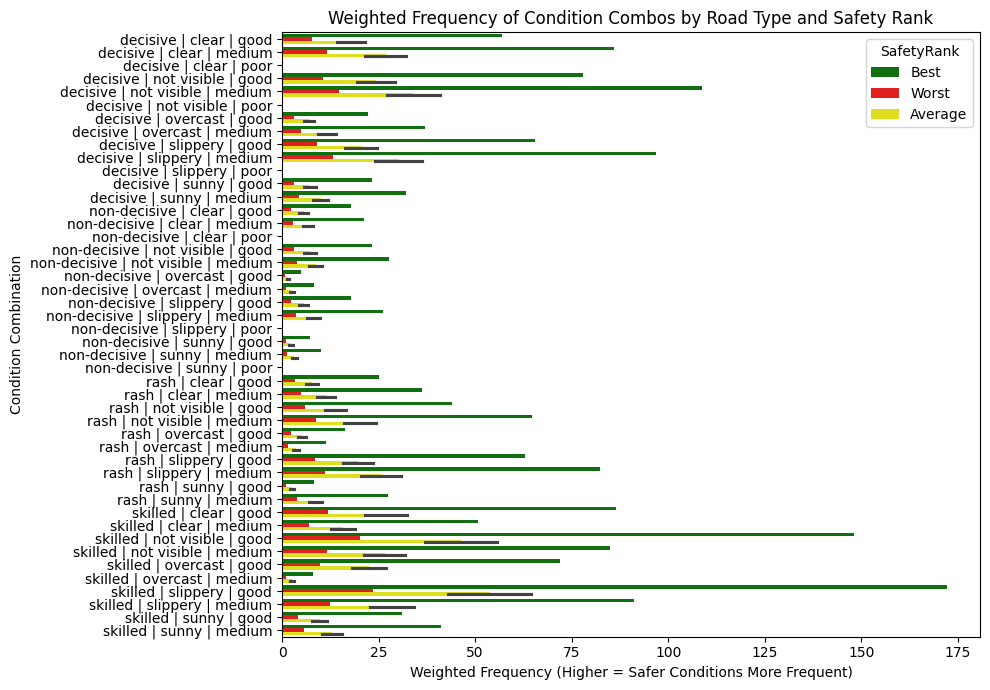

                RoadType  CP  VEP  CombinedRisk SafetyRank
0                Highway   1    2             3       Best
1  Standard Intersection   4    8            12    Average
2         T Intersection   3    5             8    Average
3             Roundabout  10   12            22      Worst


In [ ]:
# Weighted Frequency of Condition Combos by Road Type and Safety Rank

df = pd.read_csv('av_vru_combined.csv')

cols_to_clean = ['DecisiveOrStyle', 'RoadCondition', 'ChannelQuality']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.lower().str.strip()

# calculated CP & VEP values
conflict_points = {
    'highway': 1,
    'standard_intersection': 4,
    't_intersection': 3,
    'roundabout': 10   #roundabout has infinite possibilites but for variation we consider 10
}

vru_entry_points = {
    'highway': 2,
    'standard_intersection': 8,
    't_intersection': 5,
    'roundabout': 12  #same as CP, and we consider value 12
}

# score = cp + vep (safety rank)
def score(cp, vep):
    score = cp + vep
    if score <= 3:
        return 'Best'
    elif score <= 12:
        return 'Average'
    else:
        return 'Worst'

road_df = pd.DataFrame({
    'RoadType': conflict_points.keys(),
    'CP': [conflict_points[r] for r in conflict_points.keys()],
    'VEP': [vru_entry_points[r] for r in conflict_points.keys()]
})
road_df['CombinedRisk'] = road_df['CP'] + road_df['VEP']
road_df['SafetyRank'] = road_df.apply(lambda x: score(x.CP, x.VEP), axis=1)
road_df['RoadType'] = road_df['RoadType'].str.replace('_', ' ').str.title()

combo_counts = df.groupby(['DecisiveOrStyle', 'RoadCondition', 'ChannelQuality']).size().reset_index(name='Count')

expanded_rows = []
for _, row in combo_counts.iterrows():
    for _, r_row in road_df.iterrows():
        weighted_count = row['Count'] / len(road_df)  
        # weight by inverse combined risk (lower risk = higher weight)
        weight = 1 / r_row['CombinedRisk']
        weighted_value = weighted_count * weight
        
        expanded_rows.append({
            'ConditionCombo': f"{row['DecisiveOrStyle']} | {row['RoadCondition']} | {row['ChannelQuality']}",
            'RoadType': r_row['RoadType'],
            'WeightedCount': weighted_value,
            'SafetyRank': r_row['SafetyRank']
        })

weighted_df = pd.DataFrame(expanded_rows)

agg_df = weighted_df.groupby(['RoadType', 'SafetyRank', 'ConditionCombo']).sum().reset_index()

plt.figure(figsize=(10, 7))
sns.barplot(
    data=agg_df,
    x='WeightedCount',
    y='ConditionCombo',
    hue='SafetyRank',
    dodge=True,
    palette={'Best': 'green', 'Average': 'yellow', 'Worst': 'red'}
)

plt.title('Weighted Frequency of Condition Combos by Road Type and Safety Rank')
plt.xlabel('Weighted Frequency (Higher = Safer Conditions More Frequent)')
plt.ylabel('Condition Combination')
plt.legend(title='SafetyRank')
plt.tight_layout()
plt.show()

print(road_df)


B. Conflict Probability and Combined Risk Metric

Intersections were characterized using two factors:

VRU Entry Points (VEP): Predefined values for each geometry
Conflict Probability (CP): Average number of observed conflicts per intersection

We then defined a Combined Risk Metric:   Combined Risk = VEP × CP

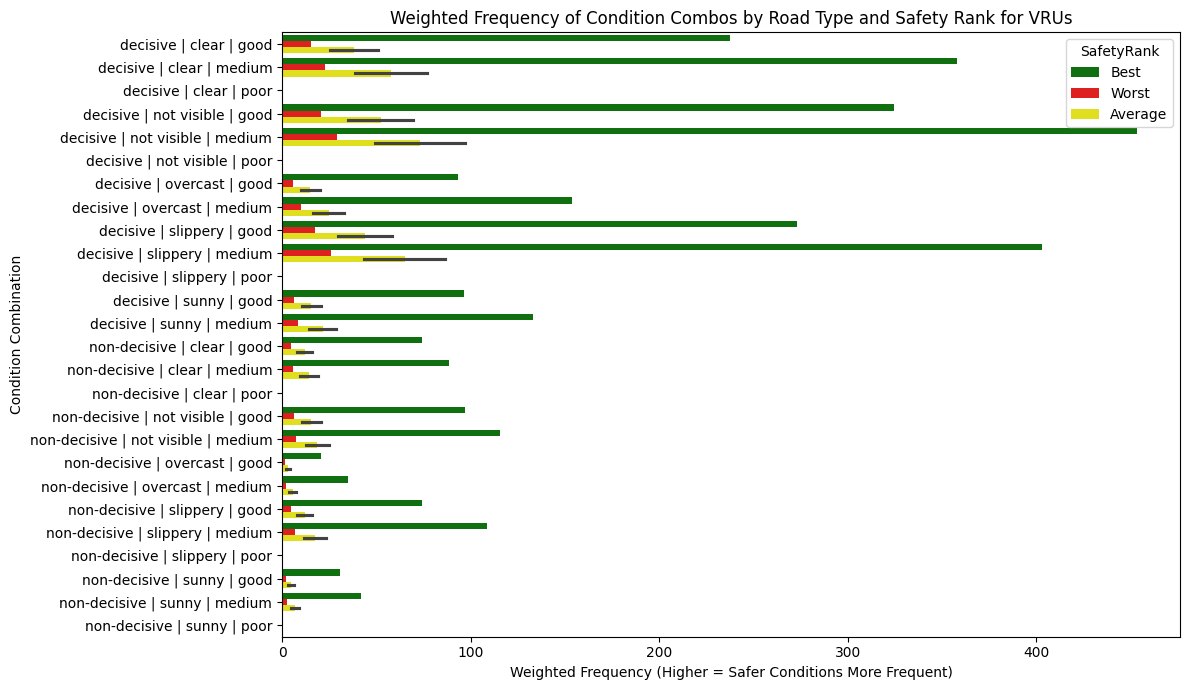

                RoadType     CP  VEP  CombinedRisk SafetyRank
0                Highway  0.360    2         0.720       Best
1  Standard Intersection  0.832    8         6.656    Average
2         T Intersection  0.672    5         3.360    Average
3             Roundabout  0.931   12        11.172      Worst


In [ ]:
# VRU Analysis

df = pd.read_csv('vru_final.csv')

cols_to_clean = ['DecisiveOrStyle', 'RoadCondition', 'ChannelQuality']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.lower().str.strip()

# calculated CP & VEP values
conflict_points = {
    'highway': 0.360,
    'standard_intersection': 0.832,
    't_intersection': 0.672,
    'roundabout': 0.931  
}

vru_entry_points = {
    'highway': 2,
    'standard_intersection': 8,
    't_intersection': 5,
    'roundabout': 12 
}

# score = cp * vep (safety rank)
def score(cp, vep):
    score = cp * vep
    if score <= 3:
        return 'Best'
    elif score <= 10:
        return 'Average'
    else:
        return 'Worst'

road_df = pd.DataFrame({
    'RoadType': conflict_points.keys(),
    'CP': [conflict_points[r] for r in conflict_points.keys()],
    'VEP': [vru_entry_points[r] for r in conflict_points.keys()]
})
road_df['CombinedRisk'] = road_df['CP'] * road_df['VEP']
road_df['SafetyRank'] = road_df.apply(lambda x: score(x.CP, x.VEP), axis=1)
road_df['RoadType'] = road_df['RoadType'].str.replace('_', ' ').str.title()

combo_counts = df.groupby(['DecisiveOrStyle', 'RoadCondition', 'ChannelQuality']).size().reset_index(name='Count')

expanded_rows = []
for _, row in combo_counts.iterrows():
    for _, r_row in road_df.iterrows():
        weighted_count = row['Count'] / len(road_df) 
        # weight by inverse combined risk (lower risk = higher weight)
        weight = 1 / r_row['CombinedRisk']
        weighted_value = weighted_count * weight
        
        expanded_rows.append({
            'ConditionCombo': f"{row['DecisiveOrStyle']} | {row['RoadCondition']} | {row['ChannelQuality']}",
            'RoadType': r_row['RoadType'],
            'WeightedCount': weighted_value,
            'SafetyRank': r_row['SafetyRank']
        })

weighted_df = pd.DataFrame(expanded_rows)

agg_df = weighted_df.groupby(['RoadType', 'SafetyRank', 'ConditionCombo']).sum().reset_index()

plt.figure(figsize=(12, 7))
sns.barplot(
    data=agg_df,
    x='WeightedCount',
    y='ConditionCombo',
    hue='SafetyRank',
    dodge=True,
    palette={'Best': 'green', 'Average': 'yellow', 'Worst': 'red'}
)

plt.title('Weighted Frequency of Condition Combos by Road Type and Safety Rank for VRUs')
plt.xlabel('Weighted Frequency (Higher = Safer Conditions More Frequent)')
plt.ylabel('Condition Combination')
plt.legend(title='SafetyRank')
plt.tight_layout()
plt.show()

print(road_df)


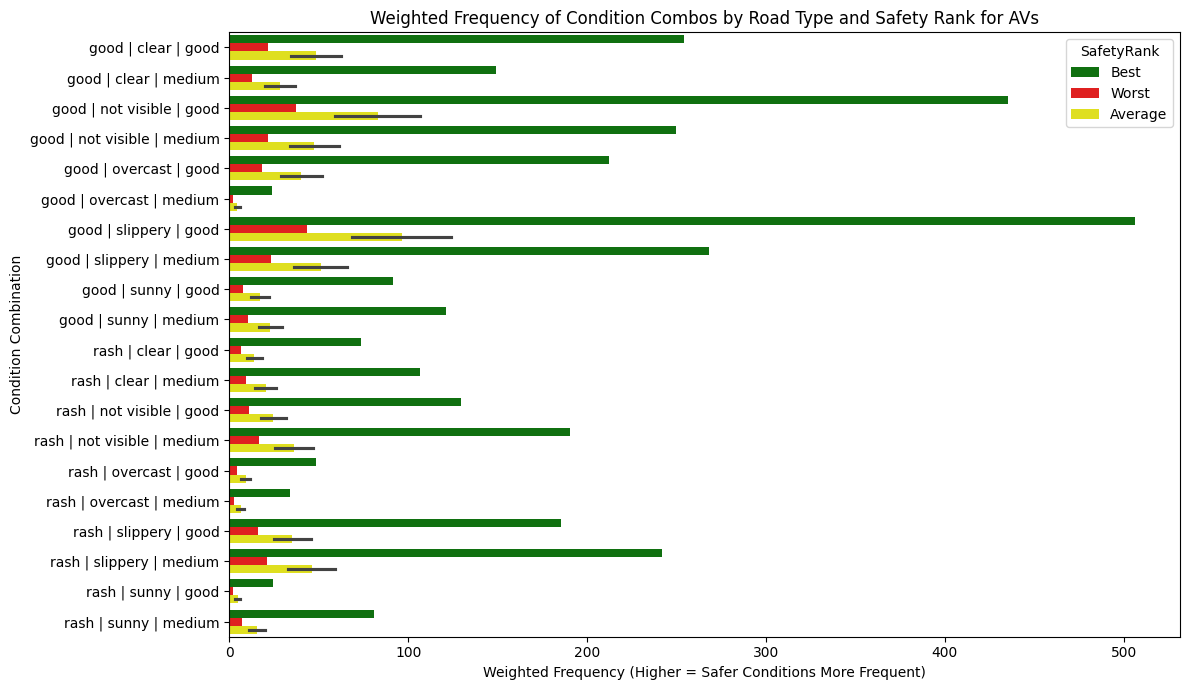

                RoadType     CP  VEP  CombinedRisk SafetyRank
0                Highway  0.510    2         1.020       Best
1  Standard Intersection  0.942    8         7.536    Average
2         T Intersection  0.832    5         4.160    Average
3             Roundabout  0.986   12        11.832      Worst


In [ ]:
# Av Analysis

df = pd.read_csv('av_final.csv')

cols_to_clean = ['DecisiveOrStyle', 'RoadCondition', 'ChannelQuality']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.lower().str.strip()

# calculated CP & VEP values
conflict_points = {
    'highway': 0.510,
    'standard_intersection': 0.942,
    't_intersection': 0.832,
    'roundabout': 0.986   
}

vru_entry_points = {
    'highway': 2,
    'standard_intersection': 8,
    't_intersection': 5,
    'roundabout': 12  
}

# score = cp * vep (safety rank)
def score(cp, vep):
    score = cp * vep
    if score <= 3:
        return 'Best'
    elif score <= 10:
        return 'Average'
    else:
        return 'Worst'

road_df = pd.DataFrame({
    'RoadType': conflict_points.keys(),
    'CP': [conflict_points[r] for r in conflict_points.keys()],
    'VEP': [vru_entry_points[r] for r in conflict_points.keys()]
})
road_df['CombinedRisk'] = road_df['CP'] * road_df['VEP']
road_df['SafetyRank'] = road_df.apply(lambda x: score(x.CP, x.VEP), axis=1)
road_df['RoadType'] = road_df['RoadType'].str.replace('_', ' ').str.title()

combo_counts = df.groupby(['DecisiveOrStyle', 'RoadCondition', 'ChannelQuality']).size().reset_index(name='Count')

expanded_rows = []
for _, row in combo_counts.iterrows():
    for _, r_row in road_df.iterrows():
        weighted_count = row['Count'] / len(road_df)
        # weight by inverse combined risk (lower risk = higher weight)
        weight = 1 / r_row['CombinedRisk']
        weighted_value = weighted_count * weight
        
        expanded_rows.append({
            'ConditionCombo': f"{row['DecisiveOrStyle']} | {row['RoadCondition']} | {row['ChannelQuality']}",
            'RoadType': r_row['RoadType'],
            'WeightedCount': weighted_value,
            'SafetyRank': r_row['SafetyRank']
        })

weighted_df = pd.DataFrame(expanded_rows)

agg_df = weighted_df.groupby(['RoadType', 'SafetyRank', 'ConditionCombo']).sum().reset_index()

plt.figure(figsize=(12, 7))
sns.barplot(
    data=agg_df,
    x='WeightedCount',
    y='ConditionCombo',
    hue='SafetyRank',
    dodge=True,
    palette={'Best': 'green', 'Average': 'yellow', 'Worst': 'red'}
)

plt.title('Weighted Frequency of Condition Combos by Road Type and Safety Rank for AVs')
plt.xlabel('Weighted Frequency (Higher = Safer Conditions More Frequent)')
plt.ylabel('Condition Combination')
plt.legend(title='SafetyRank')
plt.tight_layout()
plt.show()

print(road_df)


C. Binomial Model Validation via Monte Carlo Simulation

To validate the combined risk rankings, we implemented a Monte Carlo simulation using a binomial model. For each intersection:

1. Fix the number of VRU entry points (VEP).
2. Assign conflict probabilities for VRU and AV (pVRU, pAV).
3. Run multiple iterations to compute the probability of at least one conflict occurring.

In [ ]:
# Monte Carlo Approach

df = pd.read_csv('av_vru_combined.csv')

cols_to_clean = ['DecisiveOrStyle', 'RoadCondition', 'ChannelQuality']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.lower().str.strip()

# calculated CP & VEP values
conflict_points = {
    'highway': 0.1836,
    'standard_intersection': 0.7837,
    't_intersection': 0.5591,
    'roundabout': 0.9179  
}

vru_entry_points = {
    'highway': 2,
    'standard_intersection': 8,
    't_intersection': 5,
    'roundabout': 12  
}

# score = cp * vep (safety rank)
def score(cp, vep):
    score = cp * vep
    if score <= 2:
        return 'Best'
    elif score <= 10:
        return 'Average'
    else:
        return 'Worst'

road_df = pd.DataFrame({
    'RoadType': conflict_points.keys(),
    'CP': [conflict_points[r] for r in conflict_points.keys()],
    'VEP': [vru_entry_points[r] for r in conflict_points.keys()]
})
road_df['CombinedRisk'] = road_df['CP'] * road_df['VEP']
road_df['SafetyRank'] = road_df.apply(lambda x: score(x.CP, x.VEP), axis=1)
road_df['RoadType'] = road_df['RoadType'].str.replace('_', ' ').str.title()

combo_counts = df.groupby(['DecisiveOrStyle', 'RoadCondition', 'ChannelQuality']).size().reset_index(name='Count')

expanded_rows = []
for _, row in combo_counts.iterrows():
    for _, r_row in road_df.iterrows():
        weighted_count = row['Count'] / len(road_df)  
        weight = 1 / r_row['CombinedRisk']
        weighted_value = weighted_count * weight
        
        expanded_rows.append({
            'ConditionCombo': f"{row['DecisiveOrStyle']} | {row['RoadCondition']} | {row['ChannelQuality']}",
            'RoadType': r_row['RoadType'],
            'WeightedCount': weighted_value,
            'SafetyRank': r_row['SafetyRank']
        })

weighted_df = pd.DataFrame(expanded_rows)

agg_df = weighted_df.groupby(['RoadType', 'SafetyRank', 'ConditionCombo']).sum().reset_index()

print(road_df)


                RoadType      CP  VEP  CombinedRisk SafetyRank
0                Highway  0.1836    2        0.3672       Best
1  Standard Intersection  0.7837    8        6.2696    Average
2         T Intersection  0.5591    5        2.7955    Average
3             Roundabout  0.9179   12       11.0148      Worst


RESULTS

1. Roundabouts showed the highest combined risk due to many VRU entry points and complex right-of-way.

2. Highways had the lowest risk since VRU entry points are limited.

3. Monte Carlo results confirmed that the histogram-based combined risk metric provided realistic conflict likelihoods.

CONCLUSION

This project demonstrated a novel methodology for joint risk assessment of AVs and VRUs by combining heterogeneous datasets (PIE + RADIATE), aligning them temporally, and applying multi-factor histogram profiling, conflict probability metrics, and Monte Carlo validation. The results highlight how road geometry significantly affects safety risks, providing insights for urban planning and AV system design.